In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from torch_linregr import *

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
lambdaF = 0
lambdaD = 1e-10
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]

# Base case: 1e-7/0, 1e-3, 1e-6
# Looks pretty similar to the base case @ 0,1e-6,1e-6
# @0,1e-4,1e-4: all are broken except FLDP (still static), but EMG Norm Off with PCA On is a great (very steep) elbow plot
# @0,1e-5,1e-5: the only one that blows up is the full dataset! FLDP still static.  Magnitudes start around 6-10
# @0,1e-7,1e-6: Nothing is broken! FLDP still static.  Magnitudes start around 1
# @0,1e-7,1e-5: Full breaks but everything else looks way better! FLDP still static.
# @0,1e-8,1e-5: Full breaks but everything else looks way better! FLDP still static.
# @0,1e-8,1e-6: Everything works! FLDP still static.  
# @0,1e-9,1e-6: Everything works! FLDP still static.  
# @0,1e-10,1e-6: Everything works! FLDP still static.  


In [5]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :]).type(torch.float32)
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :]).type(torch.float32)

print(f"EMG Input size: {F1tens_full.size()}")
print(f"2D Velocity Label size: {PREF1tens_full.size()}")

Condition 1
EMG Input size: torch.Size([20770, 64])
2D Velocity Label size: torch.Size([20770, 2])


## PyTorch Linear Regression With Full Dataset

In [6]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

total_epochs_FullData = 500

Norm of Final s: 33486.9140625
Norm of emg_streamed_batch: 33485.25
Norm of D: 0.8146560192108154
Norm of V: 7600.28466796875



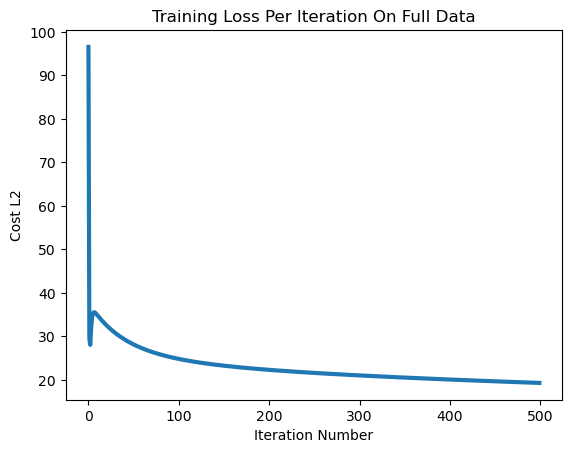

In [7]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullDat = full_train_linregr_updates(untrained_model_FullData, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, starting_update=0)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss Per Iteration On Full Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Observe performance on first update only

Norm of Post-Processed s: 7408.75
Norm of emg_streamed_batch: 7405.02099609375
Norm of D: 0.8465200662612915
Norm of V: 87.86295318603516



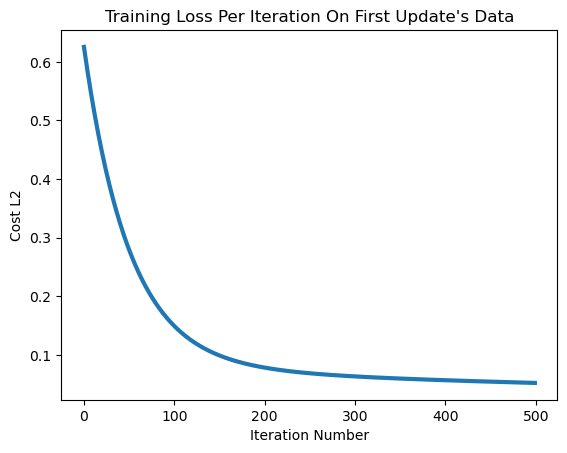

In [8]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FirstUpdate = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FirstUpdate.parameters(), lr=learning_rate)

trained_model_FirstUpdate, loss_log_FirstUpdate = full_train_linregr_updates(untrained_model_FirstUpdate, F1tens_full[update_ix[0]:update_ix[1]], PREF1tens_full[update_ix[0]:update_ix[1]], learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=total_epochs_FullData, stream_data_updates=False, use_full_input_data=True)

plt.plot(range(len(loss_log_FirstUpdate)), loss_log_FirstUpdate, linewidth=3)
plt.title("Training Loss Per Iteration On First Update's Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## PyTorch Linear Regression With Streamed Data

In [9]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

input_size = num_input_channels
output_size = 2  # 2D Velocity

Norm of Post-Processed s: 7412.6767578125
Norm of emg_streamed_batch: 7408.75
Norm of D: 0.8461489677429199
Norm of V: 85.04115295410156

Norm of Post-Processed s: 12297.6005859375
Norm of emg_streamed_batch: 12284.8759765625
Norm of D: 0.8448917865753174
Norm of V: 155.3188934326172

Norm of Post-Processed s: 7849.21923828125
Norm of emg_streamed_batch: 7846.20166015625
Norm of D: 0.8416445851325989
Norm of V: 61.82825469970703

Norm of Post-Processed s: 9085.3828125
Norm of emg_streamed_batch: 9081.1572265625
Norm of D: 0.840989887714386
Norm of V: 46.59299850463867

Norm of Post-Processed s: 6062.30810546875
Norm of emg_streamed_batch: 6060.45361328125
Norm of D: 0.8398905992507935
Norm of V: 66.64177703857422

Norm of Post-Processed s: 7455.37158203125
Norm of emg_streamed_batch: 7454.99169921875
Norm of D: 0.8391122817993164
Norm of V: 38.13105773925781

Norm of Post-Processed s: 6500.22705078125
Norm of emg_streamed_batch: 6496.6533203125
Norm of D: 0.8386470675468445
Norm of V: 

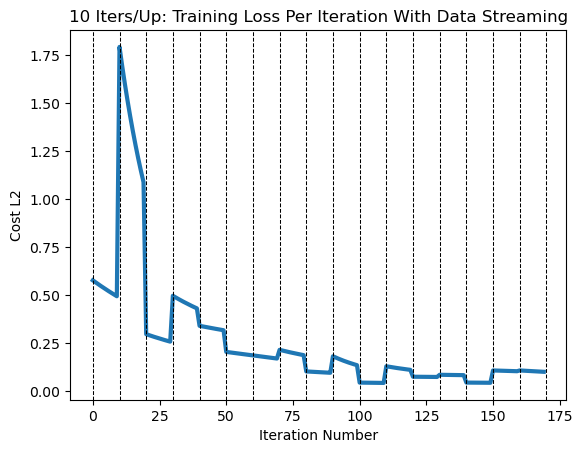

In [10]:
num_iters_per_update = 10

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Norm of Post-Processed s: 7412.6767578125
Norm of emg_streamed_batch: 7408.75
Norm of D: 0.7927418947219849
Norm of V: 157.91830444335938

Norm of Post-Processed s: 12297.6005859375
Norm of emg_streamed_batch: 12284.8759765625
Norm of D: 0.7785843014717102
Norm of V: 71.87169647216797

Norm of Post-Processed s: 7849.21923828125
Norm of emg_streamed_batch: 7846.20166015625
Norm of D: 0.7750012278556824
Norm of V: 26.61635971069336

Norm of Post-Processed s: 9085.3828125
Norm of emg_streamed_batch: 9081.1572265625
Norm of D: 0.7736798524856567
Norm of V: 23.378360748291016

Norm of Post-Processed s: 6062.30810546875
Norm of emg_streamed_batch: 6060.45361328125
Norm of D: 0.7714160084724426
Norm of V: 25.228315353393555

Norm of Post-Processed s: 7455.37158203125
Norm of emg_streamed_batch: 7454.99169921875
Norm of D: 0.769832968711853
Norm of V: 22.95238494873047

Norm of Post-Processed s: 6500.22705078125
Norm of emg_streamed_batch: 6496.6533203125
Norm of D: 0.7683475613594055
Norm of 

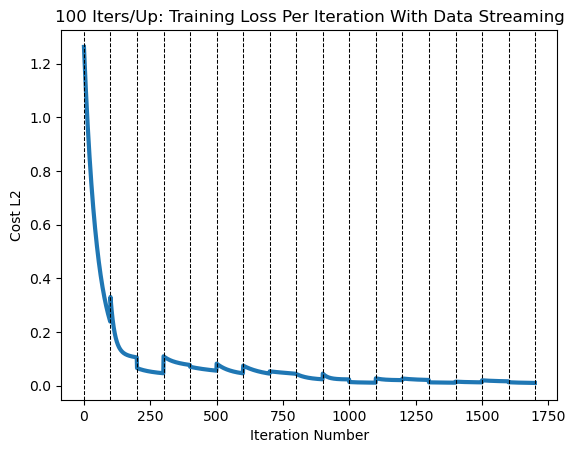

In [11]:
num_iters_per_update = 100

num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Redo but with FL Data Processing Turned On

In [12]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 7

# BUILD MODEL
num_input_channels = PCA_comps 
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity
learning_rate = 0.0001

Norm of Post-Processed s: 0.3489197790622711
Norm of emg_streamed_batch: 0.3486568033695221
Norm of D: 0.7753152251243591
Norm of V: 14.95975399017334

Norm of Post-Processed s: 0.5611228346824646
Norm of emg_streamed_batch: 0.5609199404716492
Norm of D: 0.7753152251243591
Norm of V: 15.688362121582031

Norm of Post-Processed s: 0.5182949304580688
Norm of emg_streamed_batch: 0.5180097222328186
Norm of D: 0.7753152251243591
Norm of V: 16.2189998626709

Norm of Post-Processed s: 0.516106128692627
Norm of emg_streamed_batch: 0.5157821178436279
Norm of D: 0.7753152251243591
Norm of V: 15.19472885131836

Norm of Post-Processed s: 0.45670732855796814
Norm of emg_streamed_batch: 0.45666858553886414
Norm of D: 0.7753152251243591
Norm of V: 15.862045288085938

Norm of Post-Processed s: 0.5579746961593628
Norm of emg_streamed_batch: 0.5578617453575134
Norm of D: 0.7753152251243591
Norm of V: 15.631524085998535

Norm of Post-Processed s: 0.49372899532318115
Norm of emg_streamed_batch: 0.492771714

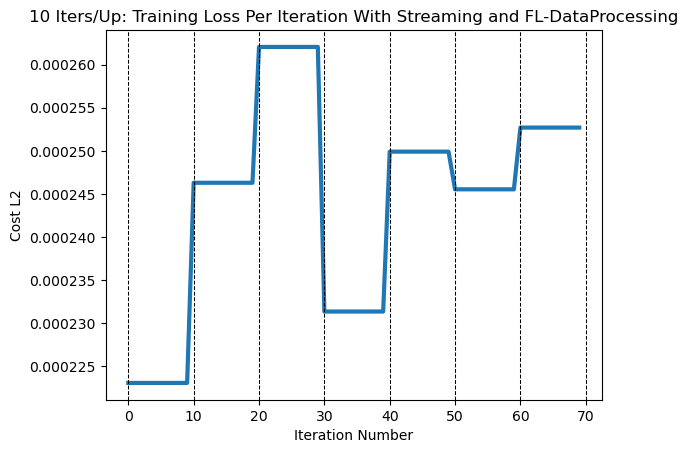

In [13]:
num_iters_per_update=10

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP.parameters(), lr=learning_rate)

trained_model_FLDP, loss_log_FLDP = full_train_linregr_updates(untrained_model_FLDP, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP)), loss_log_FLDP, linewidth=3)
plt.title("10 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Norm of Post-Processed s: 0.3489198088645935
Norm of emg_streamed_batch: 0.3486568331718445
Norm of D: 0.6771700382232666
Norm of V: 14.959636688232422

Norm of Post-Processed s: 0.5611228942871094
Norm of emg_streamed_batch: 0.5609199404716492
Norm of D: 0.6771700382232666
Norm of V: 15.688414573669434

Norm of Post-Processed s: 0.5182949304580688
Norm of emg_streamed_batch: 0.5180097818374634
Norm of D: 0.6771700382232666
Norm of V: 16.21908187866211

Norm of Post-Processed s: 0.516106128692627
Norm of emg_streamed_batch: 0.5157820582389832
Norm of D: 0.6771700382232666
Norm of V: 15.195073127746582

Norm of Post-Processed s: 0.4567074179649353
Norm of emg_streamed_batch: 0.4566686749458313
Norm of D: 0.6771700382232666
Norm of V: 15.861555099487305

Norm of Post-Processed s: 0.5579746961593628
Norm of emg_streamed_batch: 0.5578617453575134
Norm of D: 0.6771700382232666
Norm of V: 15.631359100341797

Norm of Post-Processed s: 0.4937290847301483
Norm of emg_streamed_batch: 0.492771804

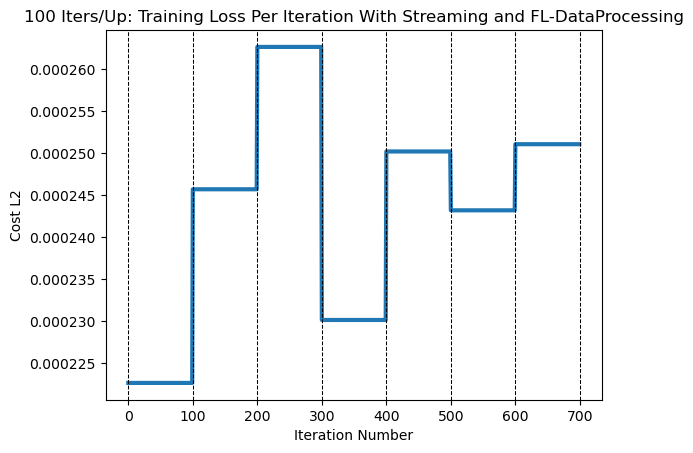

In [14]:
num_iters_per_update=100

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Investigating why the above code is trash with static cost functions

Norm EMG but no PCA

Norm of Post-Processed s: 1.000000238418579
Norm of emg_streamed_batch: 0.9992555975914001
Norm of D: 0.8144911527633667
Norm of V: 14.960175514221191

Norm of Post-Processed s: 1.000002384185791
Norm of emg_streamed_batch: 0.999947726726532
Norm of D: 0.8144911527633667
Norm of V: 15.687788963317871

Norm of Post-Processed s: 0.9999994039535522
Norm of emg_streamed_batch: 0.9992942810058594
Norm of D: 0.8144911527633667
Norm of V: 16.219932556152344

Norm of Post-Processed s: 0.9999996423721313
Norm of emg_streamed_batch: 0.999208390712738
Norm of D: 0.8144911527633667
Norm of V: 15.194258689880371

Norm of Post-Processed s: 0.9999997019767761
Norm of emg_streamed_batch: 0.9997628331184387
Norm of D: 0.8144911527633667
Norm of V: 15.861878395080566

Norm of Post-Processed s: 1.000000238418579
Norm of emg_streamed_batch: 0.9994613528251648
Norm of D: 0.8144911527633667
Norm of V: 15.632810592651367

Norm of Post-Processed s: 1.000000238418579
Norm of emg_streamed_batch: 0.9987019896507

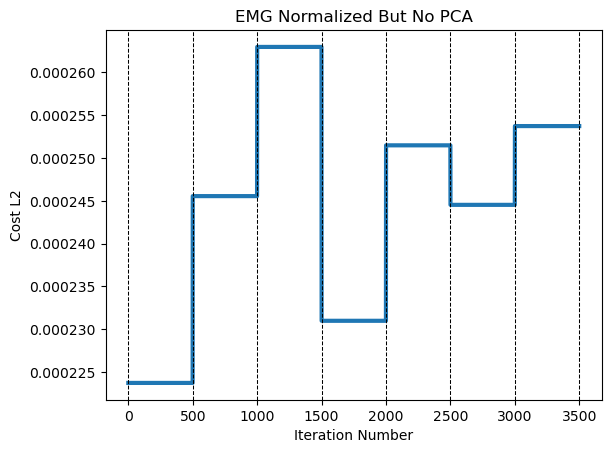

In [15]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 64

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100,  = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("EMG Normalized But No PCA")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Don't Normalize EMG but do use PCA

Norm of Post-Processed s: 2368.893310546875
Norm of emg_streamed_batch: 2367.107421875
Norm of D: 0.8716657757759094
Norm of V: 32.22688293457031

Norm of Post-Processed s: 5350.36328125
Norm of emg_streamed_batch: 5348.42822265625
Norm of D: 0.8239242434501648
Norm of V: 61.12105941772461

Norm of Post-Processed s: 3402.3994140625
Norm of emg_streamed_batch: 3400.52734375
Norm of D: 0.7788026332855225
Norm of V: 28.979658126831055

Norm of Post-Processed s: 2850.306640625
Norm of emg_streamed_batch: 2848.516357421875
Norm of D: 0.7364294528961182
Norm of V: 23.85746192932129

Norm of Post-Processed s: 3093.620849609375
Norm of emg_streamed_batch: 3093.358154296875
Norm of D: 0.7098774909973145
Norm of V: 15.742319107055664

Norm of Post-Processed s: 4448.76708984375
Norm of emg_streamed_batch: 4447.8662109375
Norm of D: 0.6866541504859924
Norm of V: 20.954561233520508

Norm of Post-Processed s: 3168.706298828125
Norm of emg_streamed_batch: 3162.5625
Norm of D: 0.6657684445381165
Norm 

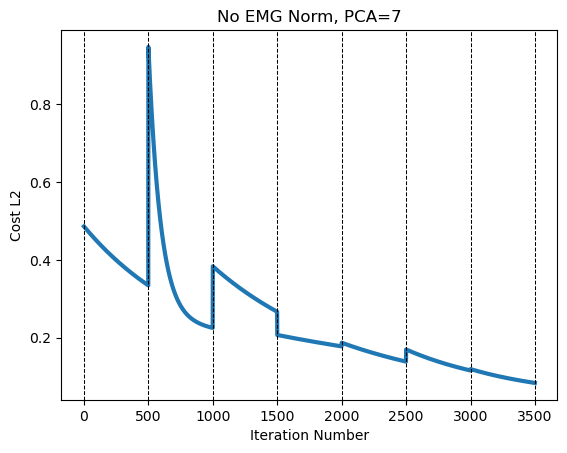

In [16]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = False
pca_channel_default = 64
PCA_comps = 7

#######################################################################

num_iters_per_update=500

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

learning_rate = 0.0001
# Other option which should give same result:
untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("No EMG Norm, PCA=7")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()